Deep Learning for Image Analysis Coursework 

Vittoria Castelnuovo - James Foster

Image Generation using a Deep Convolutional Generative Adversarial Network

Code borrowed 10% (as explained in report)

In [4]:
#Hyperparameters, DataLoading & Training

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import numpy as np
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import tqdm as tqdm
from torch.utils.data import DataLoader
from numpy import savetxt, loadtxt

from GAN import Discriminator, Generator, init_weights


#Hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

lr = 0.0002
batch_size = 128
image_size = 64
channels_img = 1
num_epochs = 1
channels_noise = 256
features_dis = 64
features_gen = 64
save_outputs = False # Plots output as images and saves them at intervals (Significantly slows down model)
save_interval = 100 # After how many epochs do you want to save the model
load_current_model = True

cuda


In [9]:
#converting images to tensors
transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))]
)

#loading in the dataset
dataset = datasets.MNIST(root='../MNIST', train=True, transform=transforms, download=True)
train_set, test_set = torch.utils.data.random_split(dataset, [40000, 20000])

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

#number or training sest images
a = len(dataset)
#print(a)

#showing the different labels for each category
b = dataset.train_labels
#print(b)

#showing that the mnist dataset is a balanced dataset, as all classes have same number of instances
c = dataset.train_labels.bincount()
#print(c) --> tensor([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949])

#Instantiating the networks
discriminator_net = Discriminator(channels_img, features_dis).to(device)
generator_net = Generator(channels_noise, channels_img, features_gen).to(device)

#initializing the weights for both networks
init_weights(discriminator_net)
init_weights(generator_net)

#optimizer
optimizer_dis = optim.Adam(discriminator_net.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_gen = optim.Adam(generator_net.parameters(), lr=lr, betas=(0.5, 0.999))

discriminator_net.train()
generator_net.train()

criterion = nn.BCELoss()

real_label = 1
fake_label = 0

fixed_noise = torch.randn(64, channels_noise, 1, 1).to(device)

step = 0

D:\Programs\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:48: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [ ]:
print("training is starting...")

# Load previsously trained models from pth file (if enabled), currently set to load longets trained and final model
# Chagne the number to brackets to eitehr 100,300,400,500,600 or NEW200 to load different models
# ADDITIONAL NOTE only 600 avialbale due to file limit
if load_current_model:
    discriminator_net.load_state_dict(torch.load('models/dis_model(600).pth'))
    generator_net.load_state_dict(torch.load('models/gen_model(600).pth'))

# Will contain avergae loss values for each epoch 
total_discriminator_loss = []
total_generator_loss = []
total_Dx = []

# Main training loop
for epoch in range(num_epochs):
    
    discriminator_loss_epoch = []
    generator_loss_epoch = []
    Dx_epoch = []
    
    for batch_idx, (data, _) in enumerate(tqdm.tqdm(train_loader, desc=f"Training Epoch {epoch+1}")):
        
        data = data.to(device)
        batch_size = data.shape[0]

        #Training the Discriminator network:
        discriminator_net.zero_grad()

        data.flatten()

        output = discriminator_net(data)

        label = (torch.ones_like(output)*0.9)

        lossD_real = criterion(output, label)
        D_x = output.mean().item()
        
        Dx_epoch.append(D_x)

        noise = torch.randn(batch_size, channels_noise, 1, 1).to(device)
        fake = generator_net(noise)
        label = (torch.ones_like(output) * 0.1).reshape(-1)

        output = discriminator_net(fake.detach()).reshape(-1)
        lossD_fake = criterion(output, label)

        lossD = lossD_real + lossD_fake
        lossD.backward()
        optimizer_dis.step()
        
        lossD = lossD.detach().cpu().numpy()  
        discriminator_loss_epoch.append(lossD)

        #Training the Generator Network:
        generator_net.zero_grad()
        output = discriminator_net(fake).reshape(-1)
        label = torch.ones_like(output)

        lossG = criterion(output, label)
        lossG.backward()
        optimizer_gen.step()
        
        lossG = lossG.detach().cpu().numpy() 
        generator_loss_epoch.append(lossG)
        
        if batch_idx % 100 == 0:
            step += 1
            #print(f"Epoch [{epoch+1}/{num_epochs}] Discriminator Loss: {lossD: .4f}, Generator Loss: {lossG: .4f} D(x): {D_x:-4f}")
            if save_outputs:
                with torch.no_grad():
                    idx = 0
                    fake = generator_net(fixed_noise)
                    img_grid_real = data[idx].cpu().numpy()
                    img_grid_fake = fake.detach()[idx].cpu().numpy()
                    plt.imshow(img_grid_real.transpose(1,2,0))
                    plt.imshow(img_grid_fake.transpose(1,2,0))
                    plt.savefig(f'gan_fake_test{epoch}_{batch_idx}.png')

    epoch_lossD = np.mean(discriminator_loss_epoch)
    epoch_lossG = np.mean(generator_loss_epoch)
    epoch_Dx = np.mean(Dx_epoch)
    
    total_discriminator_loss.append(epoch_lossD)
    total_generator_loss.append(epoch_lossG)
    total_Dx.append(epoch_Dx)
    
    #print(f"Epoch [{epoch+1}/{num_epochs}] Discriminator Loss: {epoch_lossD: .4f}, Generator Loss: {epoch_lossG: .4f} D(x): {epoch_Dx:-4f}")
    
    # Saves model after certian number fo epochs have passed
    if epoch % save_interval == 0 and epoch != 0:
        print('saving model')
        torch.save(discriminator_net.state_dict(), 'dis_model.pth')
        torch.save(generator_net.state_dict(), 'gen_model.pth')

In [ ]:
#########################################################
# All temp code for saving, loading and showing outputs #
#########################################################

# prints values from training at from each epoch afetr ttrainign ahs finished
print(total_discriminator_loss)
print(total_generator_loss)
print(total_Dx)

losstemp1 = np.array(total_discriminator_loss)
losstemp2 = np.array(total_generator_loss)
losstemp3 = np.array(total_Dx)

savetxt('discriminator_loss(x)', losstemp1, delimiter=',')
savetxt('generator_loss(x)', losstemp2, delimiter=',')
savetxt('D_x(x)', losstemp3, delimiter=',')

In [7]:
# Load the saved values from previous training
# Chagne the number to brackets to eitehr 600 or NEW200 to load different values you can plot as much or little as desired
# ADDITIONAL NOTE only 600 avialbale due to file limit
new1 = loadtxt('lossarrays/discriminator_loss(600)')
new2 = loadtxt('lossarrays/generator_loss(600)')
new3 = loadtxt('lossarrays/D_x(600)')

print(new1)
print(new2)
print(new3)

[0.97217345 1.23704088 1.21699941 1.14527845 1.05370367 0.98798132
 0.93549979 0.89402103 0.87616491 0.85236639 0.83279341 0.81262708
 0.81311327 0.81802994 0.82346582 0.82602745 0.77787173 0.79220891
 0.78954828 0.75982374 0.82179409 0.78468746 0.77164114 0.82729566
 0.73258841 0.81772649 0.77119607 0.78629798 0.76254696 0.7679196
 0.83226895 0.76784801 0.72466904 0.80454117 0.78923881 0.73874044
 0.79261142 0.7513541  0.79492426 0.74032611 0.76248014 0.78100574
 0.75552201 0.75141799 0.75538248 0.75833988 0.77198571 0.75588632
 0.7738983  0.72790086 0.78414154 0.77065116 0.7244246  0.77894801
 0.75960016 0.73499733 0.75761342 0.80762625 0.74326116 0.7503826
 0.76484889 0.75934756 0.74292004 0.73820889 0.76883394 0.70840853
 0.82003063 0.73675495 0.74775559 0.70673132 0.7371102  0.67506981
 0.68248975 0.66063052 0.66429126 0.6707291  0.66076326 0.66645026
 0.65730906 0.66117525 0.65837318 0.65593594 0.65948379 0.65925324
 0.66174865 0.65952736 0.65743208 0.65973556 0.66121632 0.657527

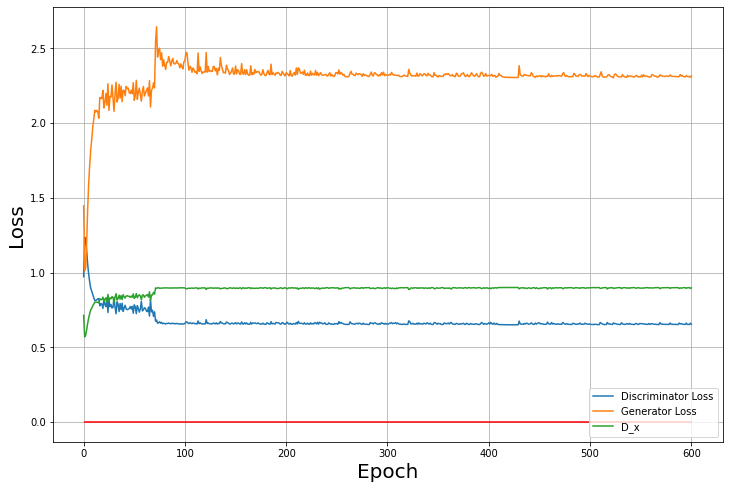

In [8]:
# PLotting code used temporarily
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
plt.plot(new1, label='Discriminator Loss')
plt.plot(new2, label='Generator Loss')
plt.plot(new3, label='D_x')
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.hlines(0, 0, len(new1), color='r')
plt.legend(loc='lower right')
plt.grid()